In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import BasicSeq2Seq
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
info = pd.read_excel("../data/info.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("../data/info.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]
norm_score = pd.read_csv(r"../data/20200315_20200415.csv")

In [2]:
power = pd.read_csv('../data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p).iloc[:, 10000:]

In [3]:
is_zero = power.values == 0
is_nan = power.isnull().values
is_valid = ~is_zero & ~is_nan

xy = np.ma.masked_array(power.values, mask=~is_valid)

series_mu = xy.mean(axis=1).data.reshape(-1, 1)
series_std = xy.std(axis=1).data.reshape(-1, 1)
xy = (xy - series_mu) / series_std
xy = xy.filled(0.)

xy = np.expand_dims(xy, 1).astype('float32')

N_TEST = 24 * 31
N_VALID = 24 * 2
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 14
time_free_space = 24

In [4]:
def n_lag(series, n):
    lag = np.zeros_like(series)
    lag[:, :, n:] = series[:, :, :-n]
    return lag

x_lag7 = n_lag(xy, 7 * 24)
x_lag14 = n_lag(xy, 14 * 24)

x_is_valid = np.expand_dims(is_valid, 1)

x_num_features = np.concatenate([x_lag7, x_lag14, x_is_valid], axis=1).astype("float32")

weights = x_is_valid.astype("float32") + 1e-6 
weights = weights * np.expand_dims(series_mu, 2) / series_mu.mean()
weights[:, :, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] = \
weights[:, :, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] * 0.1

In [5]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


# xy_weekday = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.weekday.values, 7), axis=0), xy.shape[0], axis=0)

# xy_hour = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.hour.values, 24), axis=0), xy.shape[0], axis=0)

# xy_month = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.month.values, 12), axis=0), xy.shape[0], axis=0)

xy_weekday = pd.get_dummies(power.columns.weekday).T.values
xy_hour = pd.get_dummies(power.columns.hour).T.values
xy_month = pd.get_dummies(power.columns.month).T.values
xy_date = np.concatenate([xy_weekday, xy_hour, xy_month], 0)
xy_date = np.repeat(np.expand_dims(xy_date, 0), xy.shape[0], axis=0)



def get_holiday_features(dts):
    holidays = pd.get_dummies(pd.Series(dts).apply(lambda x: calendar.get_holiday_detail(x)[1]))
    holidays['sick'] = np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)
    return holidays

holidays = get_holiday_features(power.columns)
holidays = np.expand_dims(holidays.values.transpose(1, 0), 0)
holidays = np.repeat(holidays, xy.shape[0], axis=0)

xy_num_features = np.concatenate([
    holidays,
    xy_date
], axis=1).astype('float32')

In [6]:
xy_cat_features = np.expand_dims(np.arange(62), 1)

In [8]:
xy = xy.transpose(0, 2, 1)
xy_num_features = xy_num_features.transpose(0, 2, 1)
x_num_features = x_num_features.transpose(0, 2, 1)
weights = weights.transpose(0, 2, 1)

In [18]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[1]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_TEST)

train_xy = TimeSeries(xy[:,train_idx])
valid_xy = TimeSeries(xy[:,valid_idx])

train_xy_features = TimeSeries(xy_num_features[:, train_idx])
valid_xy_features = TimeSeries(xy_num_features[:, valid_idx])

train_x_features = TimeSeries(x_num_features[:, train_idx])
valid_x_features = TimeSeries(x_num_features[:, valid_idx])

train_xy_cat = Property(xy_cat_features)
valid_xy_cat = Property(xy_cat_features)

train_weight = TimeSeries(weights[:, train_idx])
valid_weight = TimeSeries(weights[:, valid_idx])

train_frame = Seq2SeqDataLoader(train_xy, batch_size=16, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features], weights=train_weight,
                               enc_cat_feats=[train_xy_cat], dec_cat_feats=[train_xy_cat], seq_last=False)
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=64, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features],
                               weights=valid_weight, dec_cat_feats=[valid_xy_cat], enc_cat_feats=[valid_xy_cat], seq_last=False)

test_xy = xy[:, test_idx]
test_xf = np.concatenate([xy_num_features[:, test_idx], x_num_features[:, test_idx]], axis=2)
test_yf = xy_num_features[:, test_idx]
test_dec_cat = np.repeat(np.expand_dims(xy_cat_features, 2), DEC_LEN, axis=2).transpose(0, 2, 1)
test_enc_cat = np.repeat(np.expand_dims(xy_cat_features, 2), ENC_LEN, axis=2).transpose(0, 2, 1)

In [20]:
model = BasicSeq2Seq(1, 128, enc_num=54, dec_num=51, n_layers=2,
                enc_cat=[(63, 4)], dec_cat=[(63, 4)], dropout=0.)
opt = Adam(model.parameters(), 0.001)
loss_fn = MSELoss()
model.cuda()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64, eta_min=1e-4)
learner = Learner(model, opt, loss_fn, './power_env_rnn', verbose=5000, lr_scheduler=None)
learner.fit(500, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/24/2020 00:07:42]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env_rnn/logs
[[04/24/2020 00:07:43]] epoch 1 / 500, batch 100%, train loss 0.3918, valid loss 0.9235, cost 0.0 min
[[04/24/2020 00:07:43]] epoch 2 / 500, batch 100%, train loss 0.1322, valid loss 1.0575, cost 0.0 min
[[04/24/2020 00:07:44]] epoch 3 / 500, batch 100%, train loss 1.6683, valid loss 0.9355, cost 0.0 min
[[04/24/2020 00:07:44]] epoch 4 / 500, batch 100%, train loss 0.7376, valid loss 0.8799, cost 0.0 min
[[04/24/2020 00:07:44]] epoch 5 / 500, batch 100%, train loss 0.6798, valid loss 0.8452, cost 0.0 min
[[04/24/2020 00:07:45]] epoch 6 / 500, batch 100%, train loss 0.2927, valid loss 0.8189, cost 0.0 min
[[04/24/2020 00:07:45]] epoch 7 / 500, batch 100%, train loss 0.6460, valid loss 0.8048, cost 0.0 min
[[04/24/2020 00:07:46]] epoch 8 / 500, batch 100%, train loss 0.6995, valid loss 0.7891, cost 0.0 min
[[04/24/2020 00:07:46]] epoch 9 / 500, batch 100%, train loss 0.3850, valid loss 

[[04/24/2020 00:08:15]] epoch 80 / 500, batch 100%, train loss 0.3714, valid loss 0.6120, cost 0.0 min
[[04/24/2020 00:08:16]] epoch 81 / 500, batch 100%, train loss 0.2651, valid loss 0.6177, cost 0.0 min
[[04/24/2020 00:08:16]] epoch 82 / 500, batch 100%, train loss 0.1617, valid loss 0.6268, cost 0.0 min
[[04/24/2020 00:08:17]] epoch 83 / 500, batch 100%, train loss 0.5684, valid loss 0.5718, cost 0.0 min
[[04/24/2020 00:08:17]] epoch 84 / 500, batch 100%, train loss 0.3692, valid loss 0.5754, cost 0.0 min
[[04/24/2020 00:08:17]] epoch 85 / 500, batch 100%, train loss 0.2887, valid loss 0.5816, cost 0.0 min
[[04/24/2020 00:08:18]] epoch 86 / 500, batch 100%, train loss 0.1646, valid loss 0.5885, cost 0.0 min
[[04/24/2020 00:08:18]] epoch 87 / 500, batch 100%, train loss 0.2769, valid loss 0.5924, cost 0.0 min
[[04/24/2020 00:08:19]] epoch 88 / 500, batch 100%, train loss 0.2018, valid loss 0.5946, cost 0.0 min
[[04/24/2020 00:08:19]] epoch 89 / 500, batch 100%, train loss 0.1434, va

[[04/24/2020 00:08:49]] epoch 159 / 500, batch 100%, train loss 0.1393, valid loss 0.4871, cost 0.0 min
[[04/24/2020 00:08:49]] epoch 160 / 500, batch 100%, train loss 0.2253, valid loss 0.4918, cost 0.0 min
[[04/24/2020 00:08:50]] epoch 161 / 500, batch 100%, train loss 0.2736, valid loss 0.4974, cost 0.0 min
[[04/24/2020 00:08:50]] epoch 162 / 500, batch 100%, train loss 0.1863, valid loss 0.5055, cost 0.0 min
[[04/24/2020 00:08:50]] epoch 163 / 500, batch 100%, train loss 0.1849, valid loss 0.5096, cost 0.0 min
[[04/24/2020 00:08:51]] epoch 164 / 500, batch 100%, train loss 0.6455, valid loss 0.5260, cost 0.0 min
[[04/24/2020 00:08:51]] epoch 165 / 500, batch 100%, train loss 0.2635, valid loss 0.5746, cost 0.0 min
[[04/24/2020 00:08:52]] epoch 166 / 500, batch 100%, train loss 0.4088, valid loss 0.4924, cost 0.0 min
[[04/24/2020 00:08:52]] epoch 167 / 500, batch 100%, train loss 0.3371, valid loss 0.4790, cost 0.0 min
[[04/24/2020 00:08:52]] epoch 168 / 500, batch 100%, train loss 

[[04/24/2020 00:09:23]] epoch 238 / 500, batch 100%, train loss 0.2396, valid loss 0.3895, cost 0.0 min
[[04/24/2020 00:09:24]] epoch 239 / 500, batch 100%, train loss 0.2697, valid loss 0.3959, cost 0.0 min
[[04/24/2020 00:09:25]] epoch 240 / 500, batch 100%, train loss 0.2366, valid loss 0.4052, cost 0.0 min
[[04/24/2020 00:09:25]] epoch 241 / 500, batch 100%, train loss 0.2461, valid loss 0.4056, cost 0.0 min
[[04/24/2020 00:09:26]] epoch 242 / 500, batch 100%, train loss 0.1658, valid loss 0.4113, cost 0.0 min
[[04/24/2020 00:09:27]] epoch 243 / 500, batch 100%, train loss 0.2710, valid loss 0.3907, cost 0.0 min
[[04/24/2020 00:09:27]] epoch 244 / 500, batch 100%, train loss 0.0650, valid loss 0.3863, cost 0.0 min
[[04/24/2020 00:09:28]] epoch 245 / 500, batch 100%, train loss 0.3148, valid loss 0.3758, cost 0.0 min
[[04/24/2020 00:09:29]] epoch 246 / 500, batch 100%, train loss 0.1247, valid loss 0.3759, cost 0.0 min
[[04/24/2020 00:09:29]] epoch 247 / 500, batch 100%, train loss 

[[04/24/2020 00:10:12]] epoch 317 / 500, batch 100%, train loss 0.1548, valid loss 0.3811, cost 0.0 min
[[04/24/2020 00:10:13]] epoch 318 / 500, batch 100%, train loss 0.2885, valid loss 0.3769, cost 0.0 min
[[04/24/2020 00:10:14]] epoch 319 / 500, batch 100%, train loss 0.2478, valid loss 0.3665, cost 0.0 min
[[04/24/2020 00:10:14]] epoch 320 / 500, batch 100%, train loss 0.0613, valid loss 0.3540, cost 0.0 min
[[04/24/2020 00:10:15]] epoch 321 / 500, batch 100%, train loss 0.1377, valid loss 0.3570, cost 0.0 min
[[04/24/2020 00:10:16]] epoch 322 / 500, batch 100%, train loss 0.2592, valid loss 0.3724, cost 0.0 min
[[04/24/2020 00:10:16]] epoch 323 / 500, batch 100%, train loss 0.0806, valid loss 0.3942, cost 0.0 min
[[04/24/2020 00:10:17]] epoch 324 / 500, batch 100%, train loss 0.1579, valid loss 0.3934, cost 0.0 min
[[04/24/2020 00:10:17]] epoch 325 / 500, batch 100%, train loss 0.0589, valid loss 0.3867, cost 0.0 min
[[04/24/2020 00:10:18]] epoch 326 / 500, batch 100%, train loss 

[[04/24/2020 00:11:02]] epoch 396 / 500, batch 100%, train loss 0.0445, valid loss 0.3177, cost 0.0 min
[[04/24/2020 00:11:02]] epoch 397 / 500, batch 100%, train loss 0.1713, valid loss 0.3231, cost 0.0 min
[[04/24/2020 00:11:03]] epoch 398 / 500, batch 100%, train loss 0.5229, valid loss 0.3100, cost 0.0 min
[[04/24/2020 00:11:03]] epoch 399 / 500, batch 100%, train loss 0.3282, valid loss 0.3362, cost 0.0 min
[[04/24/2020 00:11:04]] epoch 400 / 500, batch 100%, train loss 0.0317, valid loss 0.3427, cost 0.0 min
[[04/24/2020 00:11:04]] epoch 401 / 500, batch 100%, train loss 0.0807, valid loss 0.3048, cost 0.0 min
[[04/24/2020 00:11:05]] epoch 402 / 500, batch 100%, train loss 0.0564, valid loss 0.3022, cost 0.0 min
[[04/24/2020 00:11:05]] epoch 403 / 500, batch 100%, train loss 0.0884, valid loss 0.3167, cost 0.0 min
[[04/24/2020 00:11:06]] epoch 404 / 500, batch 100%, train loss 0.0612, valid loss 0.3378, cost 0.0 min
[[04/24/2020 00:11:06]] epoch 405 / 500, batch 100%, train loss 

[[04/24/2020 00:11:46]] epoch 475 / 500, batch 100%, train loss 0.0466, valid loss 0.3168, cost 0.0 min
[[04/24/2020 00:11:46]] epoch 476 / 500, batch 100%, train loss 0.7236, valid loss 0.3074, cost 0.0 min
[[04/24/2020 00:11:47]] epoch 477 / 500, batch 100%, train loss 0.0486, valid loss 0.3087, cost 0.0 min
[[04/24/2020 00:11:48]] epoch 478 / 500, batch 100%, train loss 0.4470, valid loss 0.3158, cost 0.0 min
[[04/24/2020 00:11:48]] epoch 479 / 500, batch 100%, train loss 0.1019, valid loss 0.3240, cost 0.0 min
[[04/24/2020 00:11:48]] epoch 480 / 500, batch 100%, train loss 0.1785, valid loss 0.3231, cost 0.0 min
[[04/24/2020 00:11:49]] epoch 481 / 500, batch 100%, train loss 0.1203, valid loss 0.3221, cost 0.0 min
[[04/24/2020 00:11:50]] epoch 482 / 500, batch 100%, train loss 0.1255, valid loss 0.3282, cost 0.0 min
[[04/24/2020 00:11:50]] epoch 483 / 500, batch 100%, train loss 0.2032, valid loss 0.3285, cost 0.0 min
[[04/24/2020 00:11:51]] epoch 484 / 500, batch 100%, train loss 

In [48]:
learner.fit(500, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/24/2020 00:40:11]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env_rnn/logs
[[04/24/2020 00:40:11]] epoch 470 / 969, batch 100%, train loss 0.0712, valid loss 0.2966, cost 0.0 min
[[04/24/2020 00:40:12]] epoch 471 / 969, batch 100%, train loss 0.2644, valid loss 0.2947, cost 0.0 min
[[04/24/2020 00:40:13]] epoch 472 / 969, batch 100%, train loss 0.1463, valid loss 0.2889, cost 0.0 min
[[04/24/2020 00:40:13]] epoch 473 / 969, batch 100%, train loss 0.1193, valid loss 0.2913, cost 0.0 min
[[04/24/2020 00:40:14]] epoch 474 / 969, batch 100%, train loss 0.3504, valid loss 0.2947, cost 0.0 min
[[04/24/2020 00:40:15]] epoch 475 / 969, batch 100%, train loss 0.3509, valid loss 0.3157, cost 0.0 min
[[04/24/2020 00:40:15]] epoch 476 / 969, batch 100%, train loss 0.0757, valid loss 0.3120, cost 0.0 min
[[04/24/2020 00:40:16]] epoch 477 / 969, batch 100%, train loss 0.1130, valid loss 0.2942, cost 0.0 min
[[04/24/2020 00:40:17]] epoch 478 / 969, batch 100%, train loss 0

[[04/24/2020 00:41:10]] epoch 548 / 969, batch 100%, train loss 0.2169, valid loss 0.3021, cost 0.0 min
[[04/24/2020 00:41:11]] epoch 549 / 969, batch 100%, train loss 0.1245, valid loss 0.3172, cost 0.0 min
[[04/24/2020 00:41:11]] epoch 550 / 969, batch 100%, train loss 0.1291, valid loss 0.3251, cost 0.0 min
[[04/24/2020 00:41:12]] epoch 551 / 969, batch 100%, train loss 0.1240, valid loss 0.3403, cost 0.0 min
[[04/24/2020 00:41:13]] epoch 552 / 969, batch 100%, train loss 0.1956, valid loss 0.3465, cost 0.0 min
[[04/24/2020 00:41:14]] epoch 553 / 969, batch 100%, train loss 0.1384, valid loss 0.3450, cost 0.0 min
[[04/24/2020 00:41:15]] epoch 554 / 969, batch 100%, train loss 0.1714, valid loss 0.3360, cost 0.0 min
[[04/24/2020 00:41:15]] epoch 555 / 969, batch 100%, train loss 0.1090, valid loss 0.3305, cost 0.0 min
[[04/24/2020 00:41:16]] epoch 556 / 969, batch 100%, train loss 0.0615, valid loss 0.3133, cost 0.0 min
[[04/24/2020 00:41:17]] epoch 557 / 969, batch 100%, train loss 

[[04/24/2020 00:42:07]] epoch 627 / 969, batch 100%, train loss 0.2609, valid loss 0.3347, cost 0.0 min
[[04/24/2020 00:42:07]] epoch 628 / 969, batch 100%, train loss 0.1692, valid loss 0.3175, cost 0.0 min
[[04/24/2020 00:42:08]] epoch 629 / 969, batch 100%, train loss 0.1027, valid loss 0.3137, cost 0.0 min
[[04/24/2020 00:42:09]] epoch 630 / 969, batch 100%, train loss 0.2396, valid loss 0.3261, cost 0.0 min
[[04/24/2020 00:42:10]] epoch 631 / 969, batch 100%, train loss 0.2500, valid loss 0.3391, cost 0.0 min
[[04/24/2020 00:42:10]] epoch 632 / 969, batch 100%, train loss 0.1419, valid loss 0.3280, cost 0.0 min
[[04/24/2020 00:42:11]] epoch 633 / 969, batch 100%, train loss 0.0869, valid loss 0.3220, cost 0.0 min
[[04/24/2020 00:42:11]] epoch 634 / 969, batch 100%, train loss 0.0902, valid loss 0.3155, cost 0.0 min
[[04/24/2020 00:42:12]] epoch 635 / 969, batch 100%, train loss 0.1495, valid loss 0.3068, cost 0.0 min
[[04/24/2020 00:42:12]] epoch 636 / 969, batch 100%, train loss 

[[04/24/2020 00:42:57]] epoch 706 / 969, batch 100%, train loss 0.0287, valid loss 0.2866, cost 0.0 min
[[04/24/2020 00:42:58]] epoch 707 / 969, batch 100%, train loss 0.0534, valid loss 0.2961, cost 0.0 min
[[04/24/2020 00:42:59]] epoch 708 / 969, batch 100%, train loss 0.1246, valid loss 0.2838, cost 0.0 min
[[04/24/2020 00:42:59]] epoch 709 / 969, batch 100%, train loss 0.1323, valid loss 0.2684, cost 0.0 min
[[04/24/2020 00:43:00]] epoch 710 / 969, batch 100%, train loss 0.0620, valid loss 0.2678, cost 0.0 min
[[04/24/2020 00:43:01]] epoch 711 / 969, batch 100%, train loss 0.0683, valid loss 0.2719, cost 0.0 min
[[04/24/2020 00:43:02]] epoch 712 / 969, batch 100%, train loss 0.0675, valid loss 0.2809, cost 0.0 min
[[04/24/2020 00:43:02]] epoch 713 / 969, batch 100%, train loss 0.2164, valid loss 0.3016, cost 0.0 min
[[04/24/2020 00:43:03]] epoch 714 / 969, batch 100%, train loss 0.1246, valid loss 0.3258, cost 0.0 min
[[04/24/2020 00:43:04]] epoch 715 / 969, batch 100%, train loss 

[[04/24/2020 00:43:53]] epoch 785 / 969, batch 100%, train loss 0.0424, valid loss 0.4034, cost 0.0 min
[[04/24/2020 00:43:53]] epoch 786 / 969, batch 100%, train loss 0.1516, valid loss 0.3996, cost 0.0 min
[[04/24/2020 00:43:54]] epoch 787 / 969, batch 100%, train loss 0.1683, valid loss 0.3851, cost 0.0 min
[[04/24/2020 00:43:55]] epoch 788 / 969, batch 100%, train loss 0.1802, valid loss 0.3479, cost 0.0 min
[[04/24/2020 00:43:56]] epoch 789 / 969, batch 100%, train loss 1.1692, valid loss 0.3358, cost 0.0 min
[[04/24/2020 00:43:56]] epoch 790 / 969, batch 100%, train loss 0.4297, valid loss 0.3380, cost 0.0 min
[[04/24/2020 00:43:57]] epoch 791 / 969, batch 100%, train loss 0.3012, valid loss 0.3265, cost 0.0 min
[[04/24/2020 00:43:58]] epoch 792 / 969, batch 100%, train loss 0.2597, valid loss 0.3313, cost 0.0 min
[[04/24/2020 00:43:59]] epoch 793 / 969, batch 100%, train loss 0.0396, valid loss 0.3334, cost 0.0 min
[[04/24/2020 00:43:59]] epoch 794 / 969, batch 100%, train loss 

[[04/24/2020 00:44:48]] epoch 864 / 969, batch 100%, train loss 0.0901, valid loss 0.2737, cost 0.0 min
[[04/24/2020 00:44:49]] epoch 865 / 969, batch 100%, train loss 0.1195, valid loss 0.2649, cost 0.0 min
[[04/24/2020 00:44:49]] epoch 866 / 969, batch 100%, train loss 0.0766, valid loss 0.2630, cost 0.0 min
[[04/24/2020 00:44:50]] epoch 867 / 969, batch 100%, train loss 0.2082, valid loss 0.2649, cost 0.0 min
[[04/24/2020 00:44:51]] epoch 868 / 969, batch 100%, train loss 0.0737, valid loss 0.2695, cost 0.0 min
[[04/24/2020 00:44:51]] epoch 869 / 969, batch 100%, train loss 0.0817, valid loss 0.2699, cost 0.0 min
[[04/24/2020 00:44:52]] epoch 870 / 969, batch 100%, train loss 0.1089, valid loss 0.2619, cost 0.0 min
[[04/24/2020 00:44:53]] epoch 871 / 969, batch 100%, train loss 0.1829, valid loss 0.2573, cost 0.0 min
[[04/24/2020 00:44:53]] epoch 872 / 969, batch 100%, train loss 0.1012, valid loss 0.2523, cost 0.0 min
[[04/24/2020 00:44:54]] epoch 873 / 969, batch 100%, train loss 

[[04/24/2020 00:45:45]] epoch 943 / 969, batch 100%, train loss 0.1651, valid loss 0.2730, cost 0.0 min
[[04/24/2020 00:45:46]] epoch 944 / 969, batch 100%, train loss 0.1540, valid loss 0.2825, cost 0.0 min
[[04/24/2020 00:45:46]] epoch 945 / 969, batch 100%, train loss 0.4058, valid loss 0.2926, cost 0.0 min
[[04/24/2020 00:45:47]] epoch 946 / 969, batch 100%, train loss 0.0845, valid loss 0.3535, cost 0.0 min
[[04/24/2020 00:45:48]] epoch 947 / 969, batch 100%, train loss 0.6568, valid loss 0.2974, cost 0.0 min
[[04/24/2020 00:45:48]] epoch 948 / 969, batch 100%, train loss 0.1195, valid loss 0.3724, cost 0.0 min
[[04/24/2020 00:45:49]] epoch 949 / 969, batch 100%, train loss 0.1386, valid loss 0.3971, cost 0.0 min
[[04/24/2020 00:45:50]] epoch 950 / 969, batch 100%, train loss 0.1596, valid loss 0.3825, cost 0.0 min
[[04/24/2020 00:45:51]] epoch 951 / 969, batch 100%, train loss 0.3084, valid loss 0.3477, cost 0.0 min
[[04/24/2020 00:45:51]] epoch 952 / 969, batch 100%, train loss 

In [53]:
learner.fit(500, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/24/2020 01:46:32]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env_rnn/logs
[[04/24/2020 01:46:33]] epoch 874 / 1373, batch 100%, train loss 0.1623, valid loss 0.2529, cost 0.0 min
[[04/24/2020 01:46:33]] epoch 875 / 1373, batch 100%, train loss 0.0852, valid loss 0.2532, cost 0.0 min
[[04/24/2020 01:46:34]] epoch 876 / 1373, batch 100%, train loss 0.1598, valid loss 0.2537, cost 0.0 min
[[04/24/2020 01:46:35]] epoch 877 / 1373, batch 100%, train loss 0.0433, valid loss 0.2490, cost 0.0 min
[[04/24/2020 01:46:36]] epoch 878 / 1373, batch 100%, train loss 0.1569, valid loss 0.2462, cost 0.0 min
[[04/24/2020 01:46:36]] epoch 879 / 1373, batch 100%, train loss 0.0705, valid loss 0.2516, cost 0.0 min
[[04/24/2020 01:46:37]] epoch 880 / 1373, batch 100%, train loss 0.0922, valid loss 0.2585, cost 0.0 min
[[04/24/2020 01:46:38]] epoch 881 / 1373, batch 100%, train loss 0.0808, valid loss 0.2652, cost 0.0 min
[[04/24/2020 01:46:39]] epoch 882 / 1373, batch 100%, tra

[[04/24/2020 01:47:23]] epoch 952 / 1373, batch 100%, train loss 0.2364, valid loss 0.2837, cost 0.0 min
[[04/24/2020 01:47:24]] epoch 953 / 1373, batch 100%, train loss 0.3441, valid loss 0.2894, cost 0.0 min
[[04/24/2020 01:47:24]] epoch 954 / 1373, batch 100%, train loss 0.3736, valid loss 0.2822, cost 0.0 min
[[04/24/2020 01:47:25]] epoch 955 / 1373, batch 100%, train loss 0.2615, valid loss 0.2747, cost 0.0 min
[[04/24/2020 01:47:25]] epoch 956 / 1373, batch 100%, train loss 0.1284, valid loss 0.2659, cost 0.0 min
[[04/24/2020 01:47:26]] epoch 957 / 1373, batch 100%, train loss 0.1733, valid loss 0.2628, cost 0.0 min
[[04/24/2020 01:47:27]] epoch 958 / 1373, batch 100%, train loss 0.1020, valid loss 0.2631, cost 0.0 min
[[04/24/2020 01:47:27]] epoch 959 / 1373, batch 100%, train loss 0.4349, valid loss 0.2653, cost 0.0 min
[[04/24/2020 01:47:28]] epoch 960 / 1373, batch 100%, train loss 0.1399, valid loss 0.2663, cost 0.0 min
[[04/24/2020 01:47:29]] epoch 961 / 1373, batch 100%, t

[[04/24/2020 01:48:19]] epoch 1030 / 1373, batch 100%, train loss 0.1278, valid loss 0.2588, cost 0.0 min
[[04/24/2020 01:48:20]] epoch 1031 / 1373, batch 100%, train loss 0.1078, valid loss 0.2586, cost 0.0 min
[[04/24/2020 01:48:20]] epoch 1032 / 1373, batch 100%, train loss 0.2226, valid loss 0.2484, cost 0.0 min
[[04/24/2020 01:48:21]] epoch 1033 / 1373, batch 100%, train loss 0.0854, valid loss 0.2427, cost 0.0 min
[[04/24/2020 01:48:22]] epoch 1034 / 1373, batch 100%, train loss 0.2280, valid loss 0.2375, cost 0.0 min
[[04/24/2020 01:48:23]] epoch 1035 / 1373, batch 100%, train loss 0.0901, valid loss 0.2416, cost 0.0 min
[[04/24/2020 01:48:23]] epoch 1036 / 1373, batch 100%, train loss 0.1187, valid loss 0.2446, cost 0.0 min
[[04/24/2020 01:48:24]] epoch 1037 / 1373, batch 100%, train loss 0.1158, valid loss 0.2507, cost 0.0 min
[[04/24/2020 01:48:25]] epoch 1038 / 1373, batch 100%, train loss 0.2935, valid loss 0.2671, cost 0.0 min
[[04/24/2020 01:48:26]] epoch 1039 / 1373, bat

[[04/24/2020 01:49:15]] epoch 1108 / 1373, batch 100%, train loss 0.0246, valid loss 0.2755, cost 0.0 min
[[04/24/2020 01:49:16]] epoch 1109 / 1373, batch 100%, train loss 0.2838, valid loss 0.2613, cost 0.0 min
[[04/24/2020 01:49:16]] epoch 1110 / 1373, batch 100%, train loss 0.1387, valid loss 0.2560, cost 0.0 min
[[04/24/2020 01:49:17]] epoch 1111 / 1373, batch 100%, train loss 0.1242, valid loss 0.2590, cost 0.0 min
[[04/24/2020 01:49:18]] epoch 1112 / 1373, batch 100%, train loss 0.0807, valid loss 0.2817, cost 0.0 min
[[04/24/2020 01:49:19]] epoch 1113 / 1373, batch 100%, train loss 0.1276, valid loss 0.2726, cost 0.0 min
[[04/24/2020 01:49:19]] epoch 1114 / 1373, batch 100%, train loss 0.0984, valid loss 0.2618, cost 0.0 min
[[04/24/2020 01:49:20]] epoch 1115 / 1373, batch 100%, train loss 0.5799, valid loss 0.2599, cost 0.0 min
[[04/24/2020 01:49:21]] epoch 1116 / 1373, batch 100%, train loss 0.1535, valid loss 0.2496, cost 0.0 min
[[04/24/2020 01:49:21]] epoch 1117 / 1373, bat

[[04/24/2020 01:50:09]] epoch 1186 / 1373, batch 100%, train loss 0.0773, valid loss 0.2575, cost 0.0 min
[[04/24/2020 01:50:10]] epoch 1187 / 1373, batch 100%, train loss 0.0508, valid loss 0.2637, cost 0.0 min
[[04/24/2020 01:50:10]] epoch 1188 / 1373, batch 100%, train loss 0.0699, valid loss 0.2581, cost 0.0 min
[[04/24/2020 01:50:11]] epoch 1189 / 1373, batch 100%, train loss 0.1161, valid loss 0.2532, cost 0.0 min
[[04/24/2020 01:50:12]] epoch 1190 / 1373, batch 100%, train loss 0.0810, valid loss 0.2529, cost 0.0 min
[[04/24/2020 01:50:13]] epoch 1191 / 1373, batch 100%, train loss 0.0653, valid loss 0.2551, cost 0.0 min
[[04/24/2020 01:50:14]] epoch 1192 / 1373, batch 100%, train loss 0.0757, valid loss 0.2588, cost 0.0 min
[[04/24/2020 01:50:14]] epoch 1193 / 1373, batch 100%, train loss 0.3048, valid loss 0.2554, cost 0.0 min
[[04/24/2020 01:50:15]] epoch 1194 / 1373, batch 100%, train loss 0.0615, valid loss 0.2540, cost 0.0 min
[[04/24/2020 01:50:16]] epoch 1195 / 1373, bat

[[04/24/2020 01:50:57]] epoch 1263 / 1373, batch 100%, train loss 0.0382, valid loss 0.2474, cost 0.0 min
[[04/24/2020 01:50:58]] epoch 1264 / 1373, batch 100%, train loss 0.2061, valid loss 0.2425, cost 0.0 min
[[04/24/2020 01:50:58]] epoch 1265 / 1373, batch 100%, train loss 0.1160, valid loss 0.2401, cost 0.0 min
[[04/24/2020 01:50:59]] epoch 1266 / 1373, batch 100%, train loss 0.0535, valid loss 0.2435, cost 0.0 min
[[04/24/2020 01:51:00]] epoch 1267 / 1373, batch 100%, train loss 0.0946, valid loss 0.2448, cost 0.0 min
[[04/24/2020 01:51:00]] epoch 1268 / 1373, batch 100%, train loss 0.1267, valid loss 0.2452, cost 0.0 min
[[04/24/2020 01:51:01]] epoch 1269 / 1373, batch 100%, train loss 0.0559, valid loss 0.2453, cost 0.0 min
[[04/24/2020 01:51:01]] epoch 1270 / 1373, batch 100%, train loss 0.2389, valid loss 0.2406, cost 0.0 min
[[04/24/2020 01:51:02]] epoch 1271 / 1373, batch 100%, train loss 0.1553, valid loss 0.2433, cost 0.0 min
[[04/24/2020 01:51:02]] epoch 1272 / 1373, bat

[[04/24/2020 01:51:46]] epoch 1341 / 1373, batch 100%, train loss 0.2395, valid loss 0.2717, cost 0.0 min
[[04/24/2020 01:51:47]] epoch 1342 / 1373, batch 100%, train loss 0.2741, valid loss 0.2693, cost 0.0 min
[[04/24/2020 01:51:48]] epoch 1343 / 1373, batch 100%, train loss 0.0764, valid loss 0.2641, cost 0.0 min
[[04/24/2020 01:51:49]] epoch 1344 / 1373, batch 100%, train loss 0.0624, valid loss 0.2616, cost 0.0 min
[[04/24/2020 01:51:49]] epoch 1345 / 1373, batch 100%, train loss 0.1984, valid loss 0.2595, cost 0.0 min
[[04/24/2020 01:51:50]] epoch 1346 / 1373, batch 100%, train loss 0.2208, valid loss 0.2615, cost 0.0 min
[[04/24/2020 01:51:51]] epoch 1347 / 1373, batch 100%, train loss 0.1214, valid loss 0.2618, cost 0.0 min
[[04/24/2020 01:51:52]] epoch 1348 / 1373, batch 100%, train loss 0.3351, valid loss 0.2618, cost 0.0 min
[[04/24/2020 01:51:52]] epoch 1349 / 1373, batch 100%, train loss 0.0216, valid loss 0.2702, cost 0.0 min
[[04/24/2020 01:51:53]] epoch 1350 / 1373, bat

In [41]:
test_xy = torch.as_tensor(xy[:, test_idx]).cuda()
test_xf = torch.as_tensor(
    np.concatenate([xy_num_features[:, test_idx], x_num_features[:, test_idx]], axis=2)).cuda()
test_yf = torch.as_tensor(xy_num_features[:,test_idx]).cuda()
test_xy_cat = torch.as_tensor(np.repeat(np.expand_dims(xy_cat_features, 2), len(test_idx), 2).transpose(0, 2, 1)).cuda().long()

def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(name)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)


def predict(learner, xy, x_feats, y_feats, epoch):
    learner.load(epoch)
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[1] / 24 - ENC_LEN / 24 - DEC_LEN/24 + 1)
    for day in range(days):
        step = day * 24
        step_pred = model(
            xy[:,step: step+ENC_LEN], 
            enc_num=x_feats[:, step: step+ENC_LEN],
            enc_cat=test_xy_cat[:, step:step+ENC_LEN],
            dec_num=y_feats[:, step+ENC_LEN: step+ENC_LEN+DEC_LEN], 
            dec_cat=test_xy_cat[:, step+ENC_LEN: step+ENC_LEN+DEC_LEN],
            dec_len=DEC_LEN
        ).cpu().detach().numpy()
        preds.append(step_pred[:, -24:])
    
    preds = np.concatenate(preds, axis=1)
    preds = np.expm1(preds.squeeze() * series_std + series_mu)
    
    x_true = np.expm1(xy[:,:ENC_LEN + 24].cpu().numpy().squeeze() * series_std + series_mu)
    y_true = np.expm1(xy[:,ENC_LEN + 24:].cpu().numpy().squeeze() * series_std + series_mu)
    
    return x_true, y_true, preds

In [49]:
norm_data = pd.read_csv("../data/20200315_20200415.csv").drop(['Unnamed: 0', 'model_name'], axis=1)
norm_data = norm_data[norm_data.contributor_id.isin(power.index)].reset_index(drop=True)
norm_data = norm_data.set_index("contributor_id").loc[power.index].reset_index()
norm_data['data_time'] = pd.to_datetime(norm_data.data_time)
norm_data = norm_data.set_index("data_time").groupby("contributor_id").resample('1H')[['forecast_pwr', 'value']].sum().reset_index()
norm_true = norm_data.pivot(index='contributor_id', columns='data_time', values='value').iloc[:, 48:]
norm_pred = norm_data.pivot(index='contributor_id', columns='data_time', values='forecast_pwr').iloc[:, 48:]


x_true, y_true, y_pred  = predict(learner, test_xy, test_xf, test_yf, 873)
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), 
                       metric(norm_true.values, norm_pred.values).mean().rename("v1")]).T.dropna()

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [50]:
scores.describe()

wave         v1
count  62.000000  62.000000
mean    0.348705   0.526637
std     0.529058   1.994470
min     0.018358   0.017290
25%     0.136743   0.089047
50%     0.195673   0.171180
75%     0.398368   0.306400
max     3.949155  15.607201

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


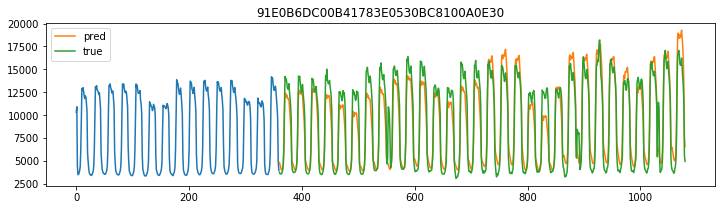

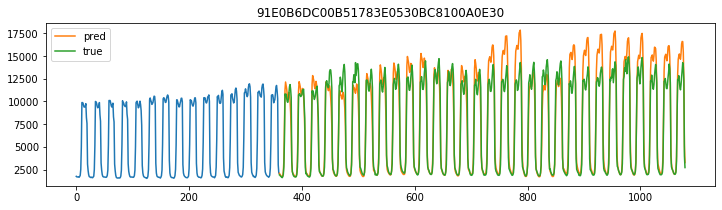

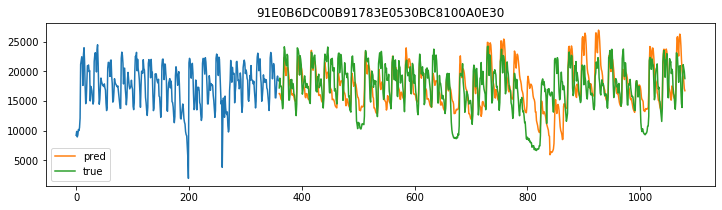

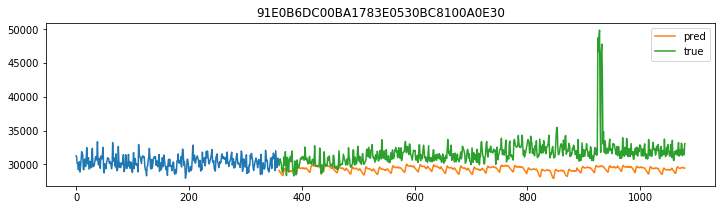

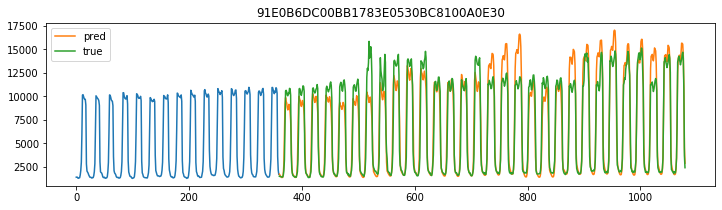

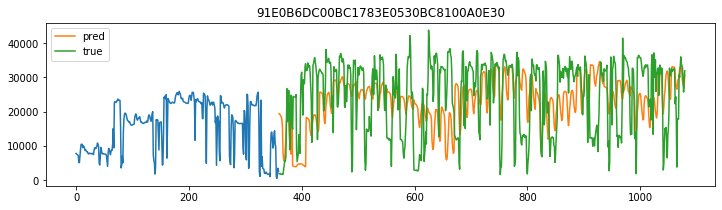

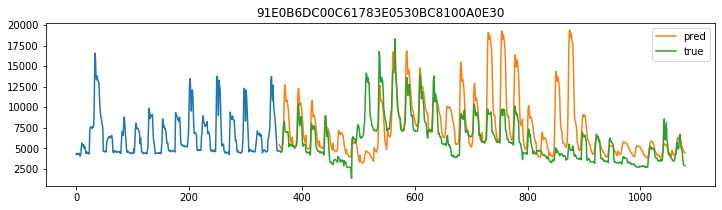

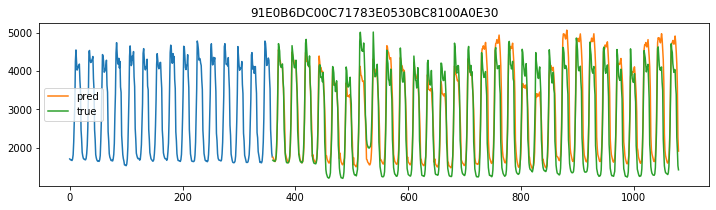

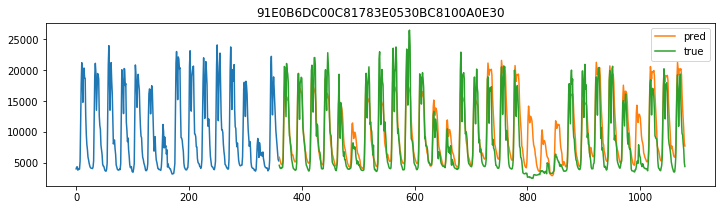

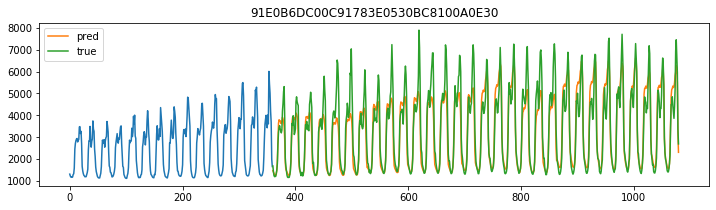

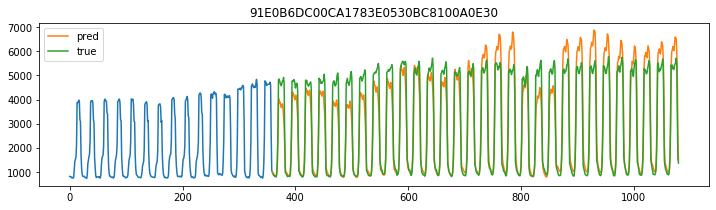

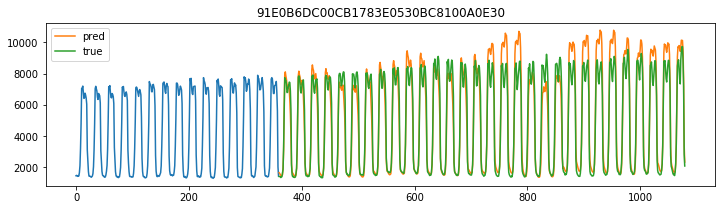

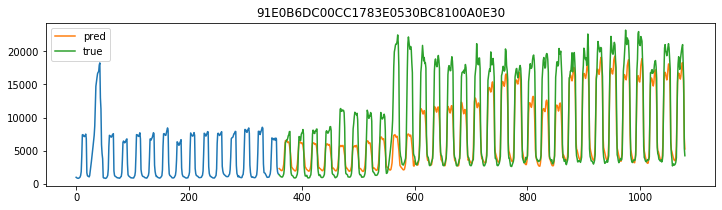

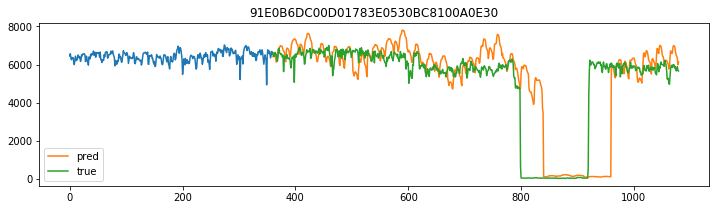

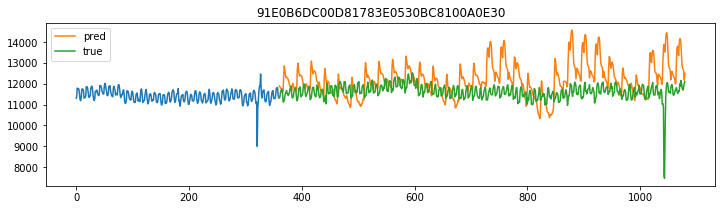

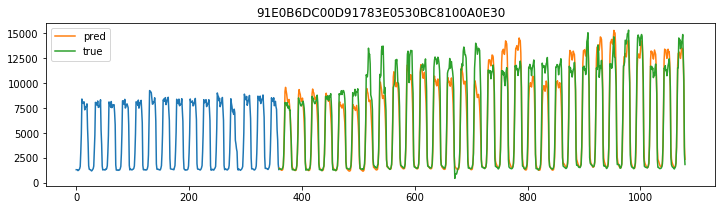

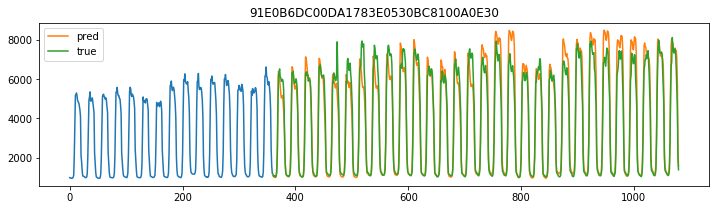

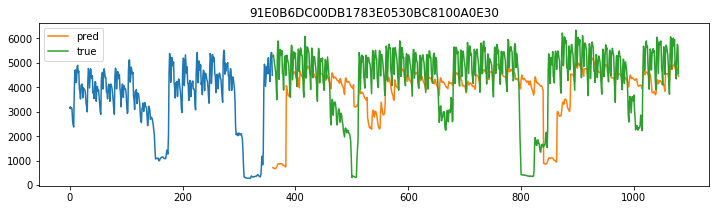

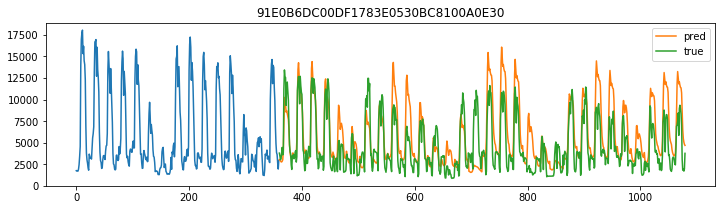

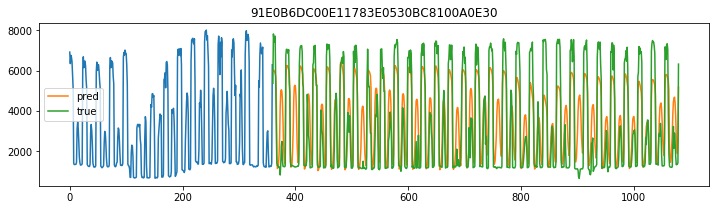

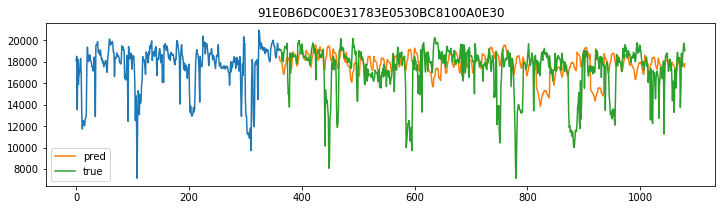

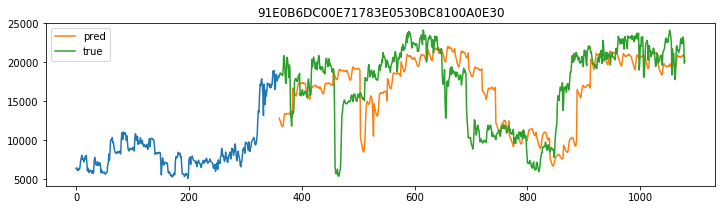

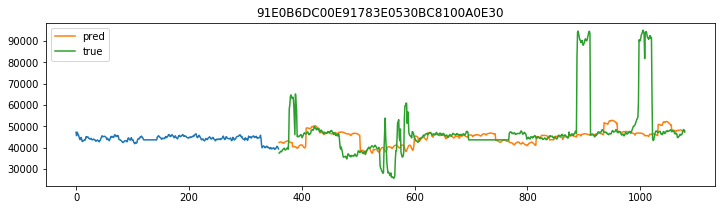

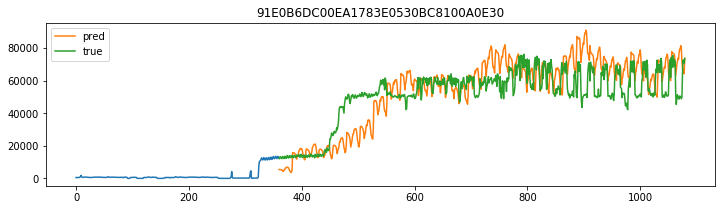

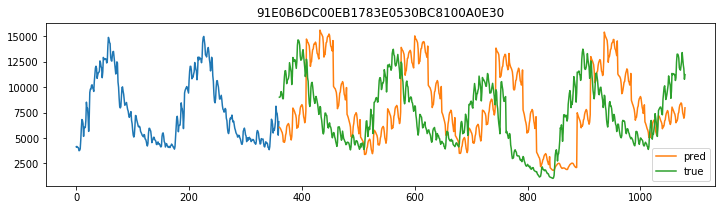

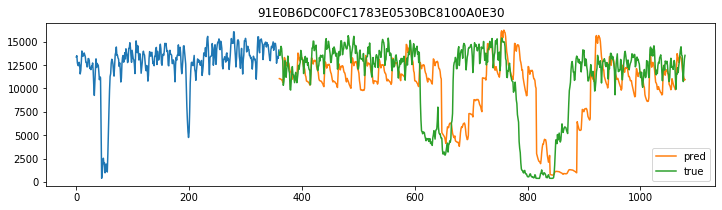

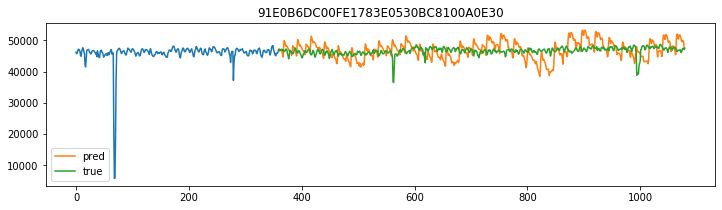

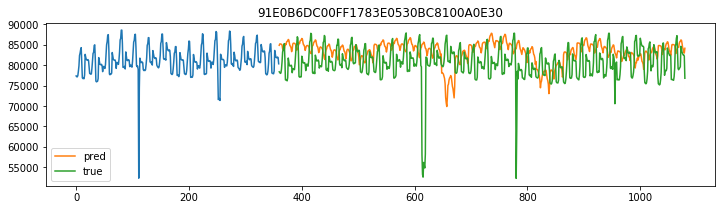

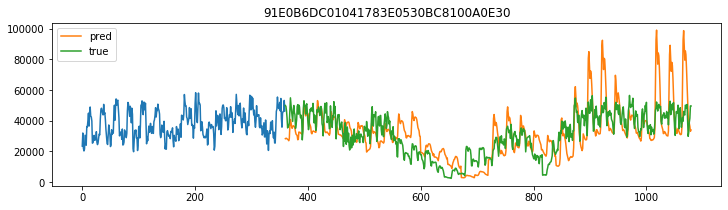

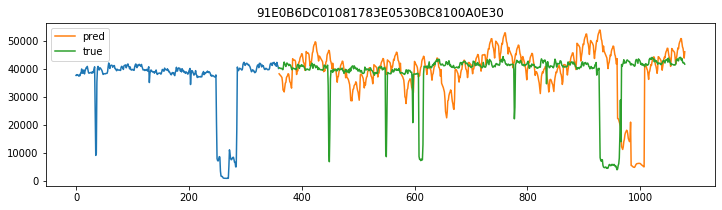

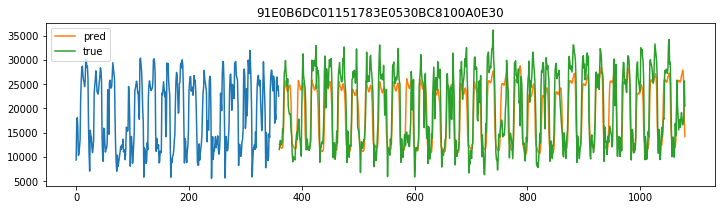

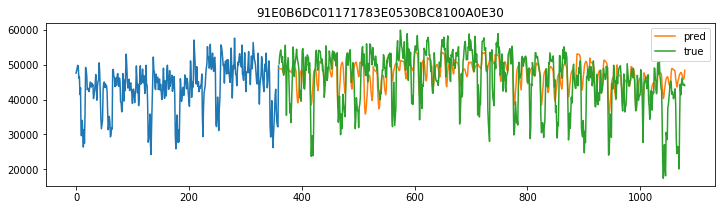

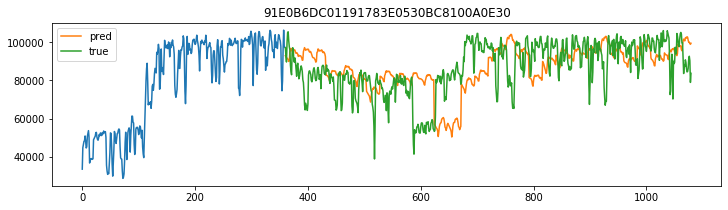

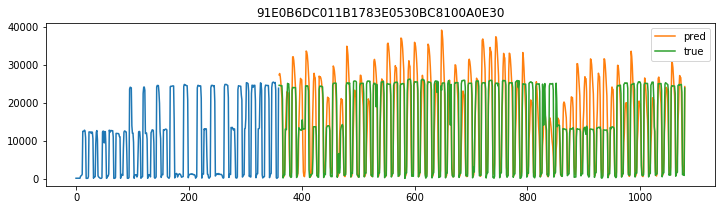

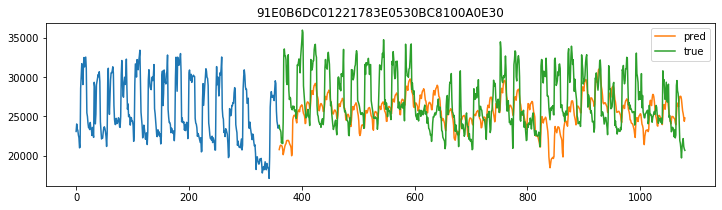

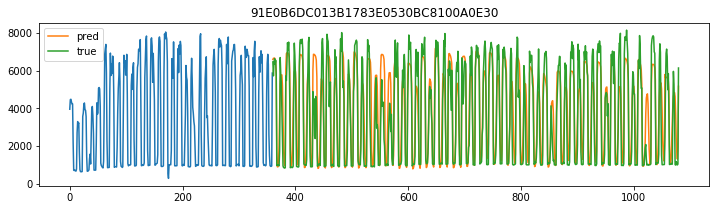

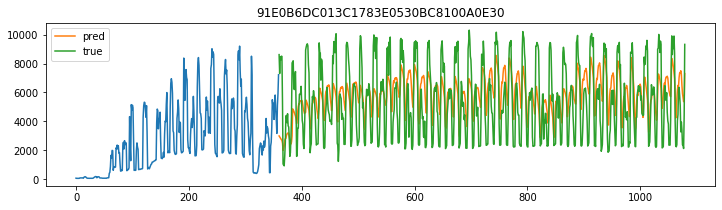

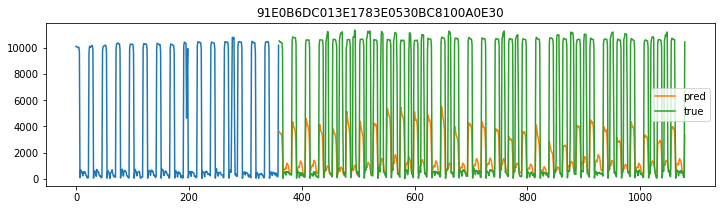

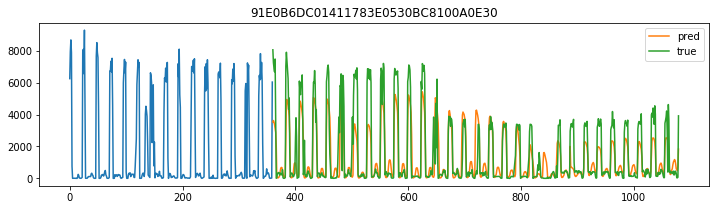

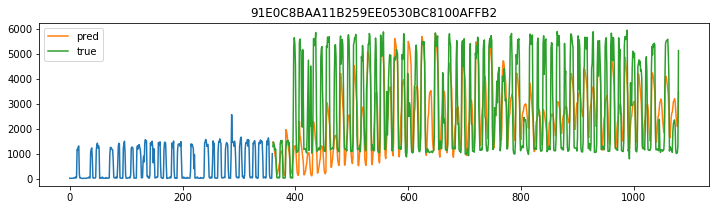

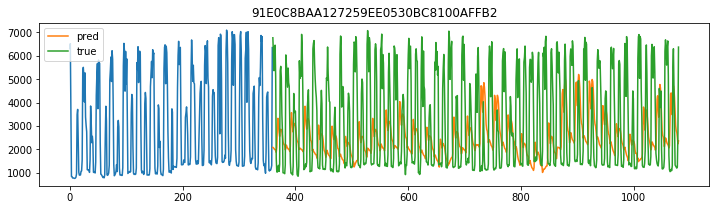

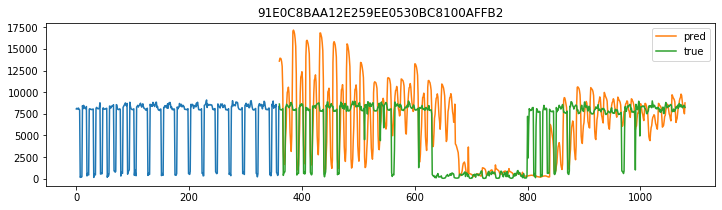

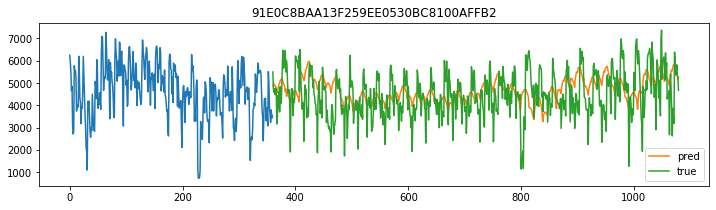

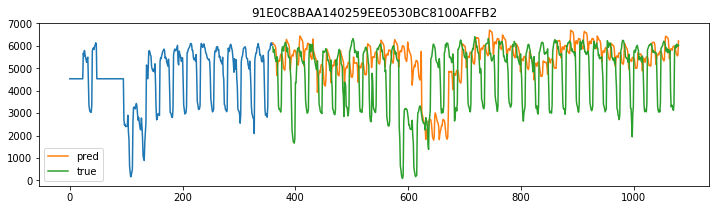

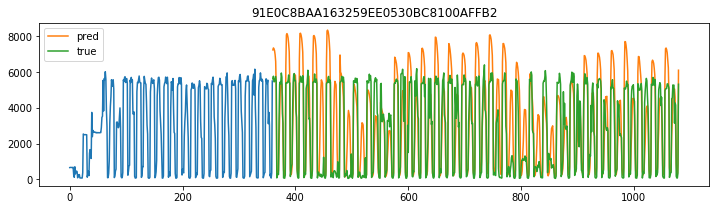

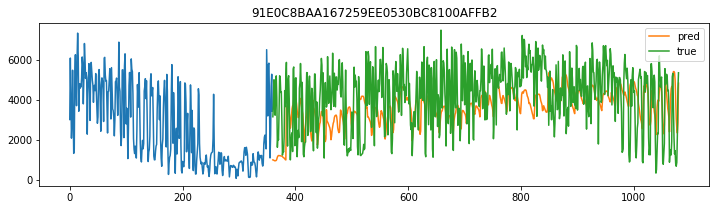

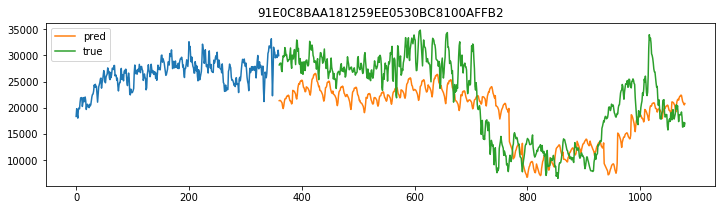

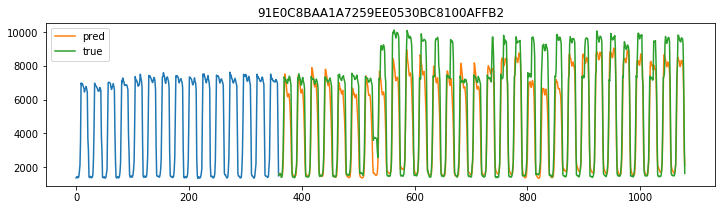

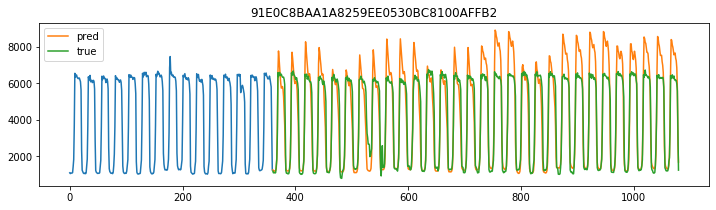

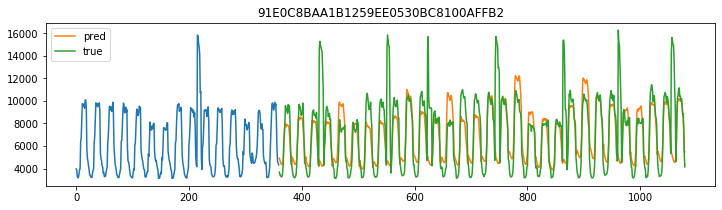

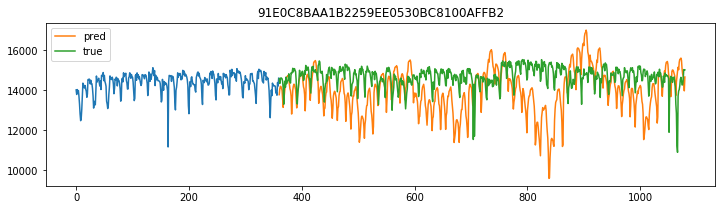

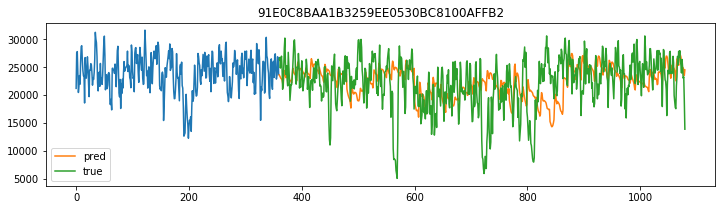

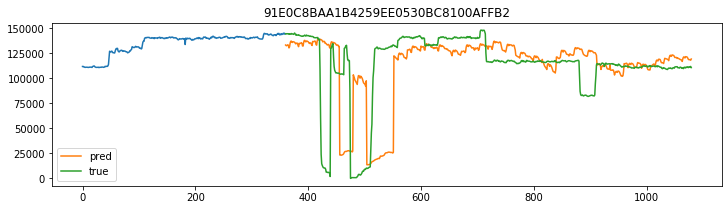

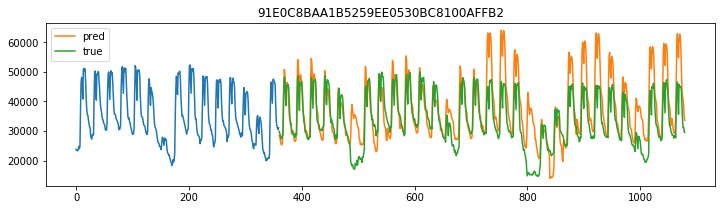

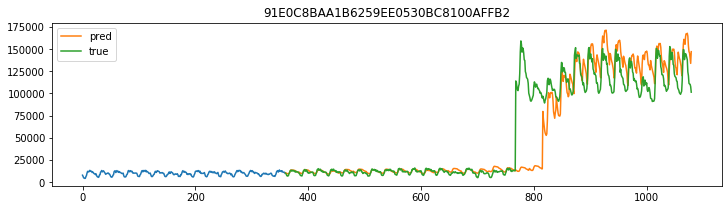

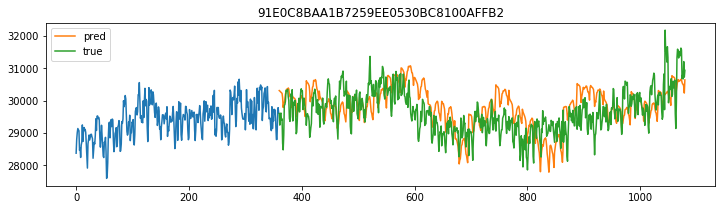

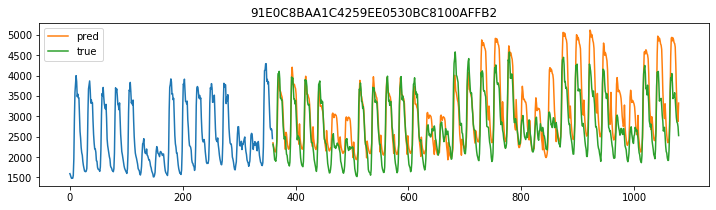

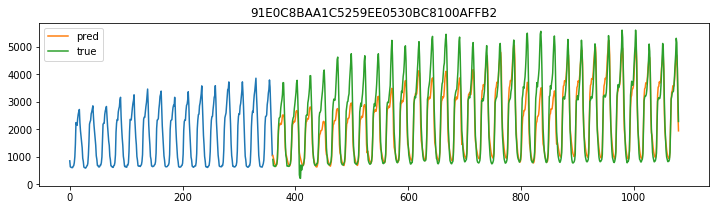

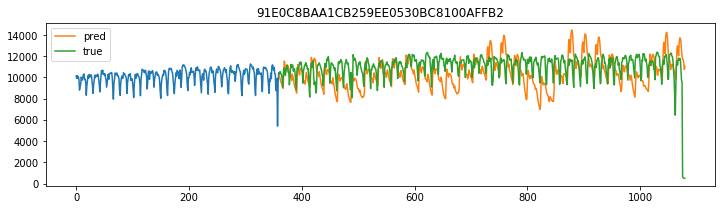

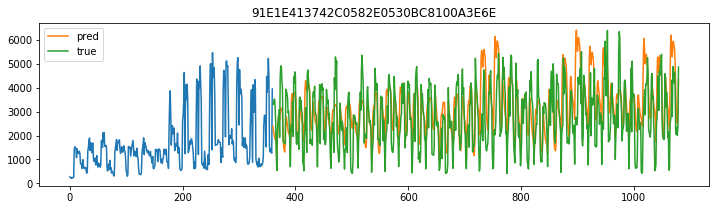

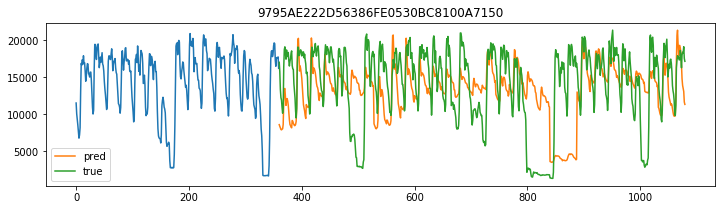

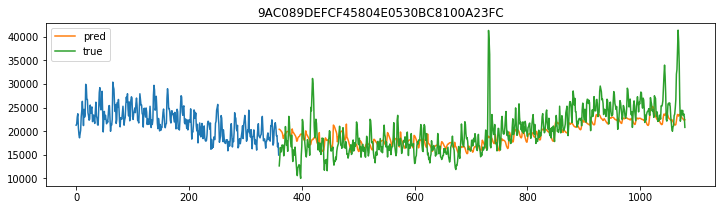

In [51]:
plot(x_true, y_true, y_pred)

In [52]:
24 * 7

168